Install kaggle and dependents to download the BUTTERFLIES dataset

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download gpiosenka/butterflies-100-image-dataset-classification

 97% 441M/454M [00:15<00:00, 35.1MB/s]
100% 454M/454M [00:15<00:00, 30.4MB/s]


In [10]:
! unzip butterflies-100-image-dataset-classification

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/MILBERTS TORTOISESHELL/111.jpg  
  inflating: train/MILBERTS TORTOISESHELL/112.jpg  
  inflating: train/MILBERTS TORTOISESHELL/113.jpg  
  inflating: train/MILBERTS TORTOISESHELL/114.jpg  
  inflating: train/MILBERTS TORTOISESHELL/115.jpg  
  inflating: train/MILBERTS TORTOISESHELL/116.jpg  
  inflating: train/MILBERTS TORTOISESHELL/117.jpg  
  inflating: train/MILBERTS TORTOISESHELL/118.jpg  
  inflating: train/MILBERTS TORTOISESHELL/119.jpg  
  inflating: train/MILBERTS TORTOISESHELL/120.jpg  
  inflating: train/MILBERTS TORTOISESHELL/121.jpg  
  inflating: train/MILBERTS TORTOISESHELL/122.jpg  
  inflating: train/MILBERTS TORTOISESHELL/123.jpg  
  inflating: train/MILBERTS TORTOISESHELL/124.jpg  
  inflating: train/MILBERTS TORTOISESHELL/125.jpg  
  inflating: train/MILBERTS TORTOISESHELL/126.jpg  
  inflating: train/MILBERTS TORTOISESHELL/127.jpg  
  inflating: train/MILBERTS TORTOISESHELL/128.jpg  
  infla

Import necessary libraries

In [11]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transform


In [12]:
train_path = "train"
test_path = "test"


Define the transform function for 2 part of the datasets, mean and standard deviation is calculated in the before session 

In [13]:
# image = (image - mean)/std

mean = [0.4840, 0.4672, 0.3431]
std = [0.2335, 0.2275, 0.2218]

train_transform = transform.Compose([
    transform.Resize((224, 224)),
    transform.RandomHorizontalFlip(),
    transform.RandomRotation(10),
    transform.ToTensor(),
    transform.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transform.Compose([
    transform.Resize((224, 224)),
    transform.ToTensor(),
    transform.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

Make dataset from images

In [14]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform= train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform= test_transform)

Define show image function

In [15]:
def show_transformed_image(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True) 
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

labels:  tensor([ 9, 43, 75, 98, 22, 66])


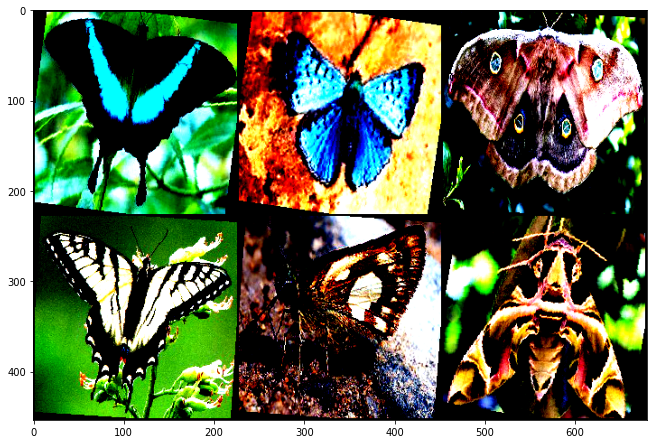

In [ ]:
show_transformed_image(train_dataset)

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, shuffle = False)

set_device() for checking if GPU device compatible

In [17]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

Evaluate accuracy, loss on each epoch

In [18]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_accuracy = 100 * predicted_correctly_on_epoch / total 
    print("    - Testing dataset. got %d out of %d images correctly (%3f%%)"
            %(predicted_correctly_on_epoch, total, epoch_accuracy))
    
    return epoch_accuracy

In [19]:
def save_checkpoint(model, epoch, optimizer, best_accuracy):
  state = {
      'epoch': epoch +1, 
      'model': model.state_dict(),
      'best accuracy': best_accuracy,
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state, 'model_best_checkpoint.pth.tar')

In [20]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_accuracy = 0.
    for epoch in range(n_epochs):
        print("epoch %d" %(epoch+1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
        
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = 100 * running_correct / total 

        print("    - Training dataset. got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
            %(running_correct, total, epoch_accuracy, epoch_loss))

        test_dataset_accuracy = evaluate_model_on_test_set(model, test_loader)  
        if test_dataset_accuracy > best_accuracy:
          best_accuracy = test_dataset_accuracy
          save_checkpoint(model, epoch, optimizer, best_accuracy)
    print("train completed")
    return model

In [ ]:
#use pretrained ResNet 18
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

resnet18 = resnet18(weights = ResNet18_Weights.DEFAULT)
num_of_features = resnet18.fc.in_features
num_of_classes = 100

resnet18.fc = nn.Linear(num_of_features, num_of_classes)
device = set_device()
resnet18 = resnet18.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)


In [ ]:

train_nn(resnet18, train_loader, test_loader, criterion=loss_function, optimizer=optimizer, n_epochs=10)


epoch 1
    - Training dataset. got 11801 out of 12639 images correctly (93.370%). Epoch loss: 0.010
    - Testing dataset. got 453 out of 500 images correctly (90.600000%)
epoch 2
    - Training dataset. got 11888 out of 12639 images correctly (94.058%). Epoch loss: 0.009
    - Testing dataset. got 471 out of 500 images correctly (94.200000%)
epoch 3
    - Training dataset. got 11869 out of 12639 images correctly (93.908%). Epoch loss: 0.009
    - Testing dataset. got 445 out of 500 images correctly (89.000000%)
epoch 4
    - Training dataset. got 11818 out of 12639 images correctly (93.504%). Epoch loss: 0.009
    - Testing dataset. got 450 out of 500 images correctly (90.000000%)
epoch 5
    - Training dataset. got 11956 out of 12639 images correctly (94.596%). Epoch loss: 0.008
    - Testing dataset. got 450 out of 500 images correctly (90.000000%)
epoch 6
    - Training dataset. got 11882 out of 12639 images correctly (94.011%). Epoch loss: 0.009
    - Testing dataset. got 451 out

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')
print(checkpoint["epoch"])
print(checkpoint["best accuracy"])

2
94.2


In [ ]:
from torchvision.models import resnet18

resnet18 = resnet18()
num_of_features = resnet18.fc.in_features
num_of_classes = 100
resnet18.fc = nn.Linear(num_of_features, num_of_classes)

resnet18.load_state_dict(checkpoint["model"])

torch.save(resnet18, "best_model.pth")

In [68]:
class CNN(nn.Module):
	# conv output = floor (input - kernel + 2*padding)/stride + 1 
	# pooling output = floor (input - kernel)/stride
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 1, stride=2)
		self.relu = nn.ReLU()
		self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, stride=1, dilation = 1)
		self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride=2)
		self.fc1 = nn.Linear(64*7*7, 512)
		self.fc2 = nn.Linear(512, 100)

		# self.model = nn.Sequential(
		# 	#Input = 3 x 224 x 224, Output = 32 x 112 x 112
		# 	nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 1, stride=2),
		# 	nn.ReLU(),

		# 	#Input = 32 x 112 x 112, Output = 32 x 66 x 66
		# 	nn.MaxPool2d(kernel_size=2),

		# 	#Input = 32 x 66 x 66, Output = 64 x 33 x 33
		# 	nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
		# 	nn.ReLU(),
		# 	#Input = 64 x 33 x 33, Output = 64 x 16 x 16
		# 	nn.MaxPool2d(kernel_size=2),
			
		# 	#Input = 64 x 16 x 16, Output = 64 x 8 x 8
		# 	nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
		# 	nn.ReLU(),
		# 	#Input = 64 x 8 x 8, Output = 64 x 4 x 4
		# 	nn.MaxPool2d(kernel_size=2),

		# 	nn.Flatten(),
		# 	nn.Linear(64*4*4, 512),
		# 	nn.ReLU(),
		# 	nn.Linear(512, 100)
		# )

	def forward(self, x):
		# return self.model(x)
			x = self.pool(self.relu(self.conv1(x)))
			x = self.pool(self.relu(self.conv2(x)))
			x = self.pool(self.relu(self.conv3(x))) 
			x = torch.flatten(x, 1) # flatten all dimensions except batch
			x = self.relu(self.fc1(x))
			x = self.fc2(x)
			return x



In [73]:
device = set_device()
convNet = CNN().to(device)

In [74]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(convNet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [76]:
train_nn(convNet, train_loader, test_loader, criterion=loss_function, optimizer=optimizer, n_epochs=25)

epoch 1
    - Training dataset. got 10294 out of 12639 images correctly (81.446%). Epoch loss: 0.020
    - Testing dataset. got 384 out of 500 images correctly (76.800000%)
epoch 2
    - Training dataset. got 10529 out of 12639 images correctly (83.306%). Epoch loss: 0.018
    - Testing dataset. got 405 out of 500 images correctly (81.000000%)
epoch 3
    - Training dataset. got 10548 out of 12639 images correctly (83.456%). Epoch loss: 0.017
    - Testing dataset. got 404 out of 500 images correctly (80.800000%)
epoch 4
    - Training dataset. got 10794 out of 12639 images correctly (85.402%). Epoch loss: 0.016
    - Testing dataset. got 390 out of 500 images correctly (78.000000%)
epoch 5
    - Training dataset. got 10805 out of 12639 images correctly (85.489%). Epoch loss: 0.016
    - Testing dataset. got 423 out of 500 images correctly (84.600000%)
epoch 6
    - Training dataset. got 10920 out of 12639 images correctly (86.399%). Epoch loss: 0.015
    - Testing dataset. got 414 out

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
)

Test Layer hyperparam

In [27]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [30]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [52]:
conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 2, stride=2)
relu = nn.ReLU()
pool = nn.MaxPool2d(kernel_size=2, stride = 2)
conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, stride=1, dilation = 1)
conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride=2)

In [53]:
x = conv1(images)
print(x.shape)

torch.Size([32, 32, 112, 112])


In [54]:
y = pool(x)
print(y.shape)

torch.Size([32, 32, 56, 56])


In [55]:
z = conv2(y)
print(z.shape)

torch.Size([32, 64, 56, 56])


In [56]:
t = pool(z)
print(t.shape)

torch.Size([32, 64, 28, 28])


In [57]:
w = conv3(t)
print(w.shape)

torch.Size([32, 64, 14, 14])


In [58]:
u = pool(w)
print(u.shape)

torch.Size([32, 64, 7, 7])
